# scPrinter setup for Bos taurus
Our goal? Being to characterize differential TF profiles between peak and late lactation

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import json
import csv
import re
from sklearn.preprocessing import OneHotEncoder

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

In [2]:
work_dir="/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man"
genome_dir="/net/talisker/home/benos/mae117/.local/share/genomes/bosTau9"
frags_dir_controls="/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/controls/bostau9/fragments"
frags_dir_peaks="/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/peak/bostau9/fragments"
frags_dir_late="/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/late/bostau9/fragments"

In [3]:
# controls_files=os.listdir(frags_dir_controls)
# controls_files_frags=[i for i in controls_files if i.endswith(".fragments.tsv.gz")]
# controls_files_frags=sorted([os.path.join(frags_dir_controls, i) for i in controls_files_frags])
# controls_files_samples=["_".join(re.split("[/_\\.]", i)[11:13]) for i in controls_files_frags]

In [4]:
peak_files=os.listdir(frags_dir_peaks)
peak_files_frags=[i for i in peak_files if i.endswith(".fragments.tsv.gz")]
peak_files_frags=sorted([os.path.join(frags_dir_peaks, i) for i in peak_files_frags])
peak_files_samples=["_".join(re.split("[/_\\.]", i)[11:13]) for i in peak_files_frags]

In [5]:
late_files=os.listdir(frags_dir_late)
late_files_frags=[i for i in late_files if i.endswith(".fragments.tsv.gz")]
late_files_frags=sorted([os.path.join(frags_dir_late, i) for i in late_files_frags])
late_files_samples=["_".join(re.split("[/_\\.]", i)[11:13]) for i in late_files_frags]

## Create a custom bosTau9 for scPrinter to work on!

### We need to build a [custom genome object](https://ruochiz.com/scprinter_doc/tutorials/custom_genome_tutorial.html) for cows RE scPrinter


* Read in the chromosome sizes of the cow genome as a dictionary

In [6]:
#os.mkdir(os.path.join(work_dir, "data/custom_genomes/ARS-UCD2.0"))

# sizes have to be read in like a dictionary
chrom_sizes = {}
with open(os.path.join(genome_dir, "bosTau9.fa.sizes")) as f:
    for line in f:
       (key, val) = line.split()
       chrom_sizes[key] = int(val)

* Create a bias file for bosTau9

In [7]:
pretrain_Tn5_bias_model = scp.datasets.pretrained_Tn5_bias_model
pretrain_Tn5_bias_model

'/net/talisker/home/benos/mae117/.cache/scprinter/Tn5_NN_model_py_v2.pt'

In [8]:
scp.genome.predict_genome_tn5_bias(fa_file=str(os.path.join(genome_dir, "bosTau9.fa")),
                            save_name=f"{work_dir}/data/bias.bosTau9.h5",
                            tn5_model=pretrain_Tn5_bias_model,
                            context_radius=50,
                            device="cuda",
                            batch_size=5000)

Predicting Tn5 bias:   0%|          | 0/2211 [00:00<?, ?it/s]

* Create the custom genome

In [9]:
def make_btau_splits(with_chr_prefix=True, include_mt=False):
    """
    Create five 'reasonable' bosTau9 chromosome splits (train/valid/test) in the
    same structure as the human example. Partitions are disjoint and exhaustive.

    Args:
        with_chr_prefix (bool): if True, chromosomes are named 'chr1'...'chr29','chrX','chrY' (and 'chrMT' if included)
                                if False, they are '1'...'29','X','Y' ('MT' if included)
        include_mt (bool): include mitochondrial chromosome in the partitions.

    Returns:
        List[Dict[str, List[str]]]: five dicts with keys 'train', 'valid', 'test'
    """

    # bosTau9 autosomes 1..29 plus sex chromosomes
    autosomes = [f"chr{str(i)}" for i in range(1, 30)]
    sex = ["chrX"] # excluding Y, these are female samples
    mt = ["MT"] if include_mt else []
    all_chroms = autosomes + sex + mt

    # Helper to add/remove 'chr' prefix
    def lab(c):
        #return f"chr{c}" if with_chr_prefix else c
        return f"{c}" if with_chr_prefix else c

    # ----
    # Pre-chosen, balanced-ish folds (mix large+medium+small autosomes, spread X/Y across folds)
    # These are *chromosome labels without prefix*; we’ll map to prefixed labels at the end.
    # Each fold lists its 'test' and 'valid' sets; 'train' is derived as set difference of all_chroms.

    folds_spec = [
        # Fold 1
        {
            "test":  ["chr1", "chr3", "chr6", "chr12", "chr24"],
            "valid": ["chr8", "chr20"],
        },
        # Fold 2
        {
            "test":  ["chr2", "chr9", "chr16", "chr21", "chr27"],
            "valid": ["chr12", "chr17"],
        },
        # Fold 3
        {
            "test":  ["chr4", "chr11", "chr15", "chr19", "chr29", "chrX"],
            "valid": ["chr7", "chr22"],
        },
        # Fold 4
        {
            "test":  ["chr5", "chr10", "chr14", "chr18", "chr20", "chr26"],
            "valid": ["chr6", "chr21"],
        },
        # Fold 5
        {
            "test":  ["chr7", "chr13", "chr17", "chr23", "chr25", "chrX"],
            "valid": ["chr10", "chr18"],
        },
    ]

    # Optionally distribute MT (if included), put it into validation of Fold 1
    if include_mt:
        folds_spec[0]["valid"] = folds_spec[0]["valid"] + ["MT"]

    # Build full folds, enforcing disjoint/exhaustive partition per fold
    folds = []
    all_set = set(all_chroms)
    for spec in folds_spec:
        test = set(spec["test"])
        valid = set(spec["valid"])
        # Sanity: ensure declared sets exist
        assert test.isdisjoint(valid), "test and valid overlap in spec"
        assert test.issubset(all_set) and valid.issubset(all_set), "spec includes unknown chromosomes"
        train = sorted(all_set - test - valid, key=lambda x: (x not in sex+mt, x))  # stable-ish sort

        fold = {
            "test":  sorted([lab(c) for c in test],  key=lambda x: (x not in {lab("X"), lab("Y"), lab("MT")}, x)),
            "valid": sorted([lab(c) for c in valid], key=lambda x: (x not in {lab("X"), lab("Y"), lab("MT")}, x)),
            "train": sorted([lab(c) for c in train], key=lambda x: (x not in {lab("X"), lab("Y"), lab("MT")}, x)),
        }
        folds.append(fold)

    return folds

btau_splits = make_btau_splits(with_chr_prefix=True, include_mt=False)
btau_splits

[{'test': ['chr1', 'chr12', 'chr24', 'chr3', 'chr6'],
  'valid': ['chr20', 'chr8'],
  'train': ['chr10',
   'chr11',
   'chr13',
   'chr14',
   'chr15',
   'chr16',
   'chr17',
   'chr18',
   'chr19',
   'chr2',
   'chr21',
   'chr22',
   'chr23',
   'chr25',
   'chr26',
   'chr27',
   'chr28',
   'chr29',
   'chr4',
   'chr5',
   'chr7',
   'chr9',
   'chrX']},
 {'test': ['chr16', 'chr2', 'chr21', 'chr27', 'chr9'],
  'valid': ['chr12', 'chr17'],
  'train': ['chr1',
   'chr10',
   'chr11',
   'chr13',
   'chr14',
   'chr15',
   'chr18',
   'chr19',
   'chr20',
   'chr22',
   'chr23',
   'chr24',
   'chr25',
   'chr26',
   'chr28',
   'chr29',
   'chr3',
   'chr4',
   'chr5',
   'chr6',
   'chr7',
   'chr8',
   'chrX']},
 {'test': ['chr11', 'chr15', 'chr19', 'chr29', 'chr4', 'chrX'],
  'valid': ['chr22', 'chr7'],
  'train': ['chr1',
   'chr10',
   'chr12',
   'chr13',
   'chr14',
   'chr16',
   'chr17',
   'chr18',
   'chr2',
   'chr20',
   'chr21',
   'chr23',
   'chr24',
   'chr25',
 

In [10]:
momoo = scp.genome.Genome(
    name=str(os.path.join(work_dir, "data/custom_genomes/bosTau9")),
    chrom_sizes=chrom_sizes,
    gff_file=f"{genome_dir}/bosTau9.annotation.gtf",
    fa_file=f"{genome_dir}/bosTau9.fa",
    bias_file=f"{work_dir}/data/bias.bosTau9.h5",
    blacklist_file=f"{genome_dir}/bosTau9.blacklist.bed", # empty bed file
    bg=None,
    splits=btau_splits
)

In [11]:
import pickle
pickle.dump(momoo, open(f"{work_dir}/data/custom_genomes/bosTau9", "wb"))

## Create scPrinter object(s)

In [17]:
objects = []
with (open(f"{work_dir}/data/custom_genomes/bosTau9", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

momoo=objects[0]
momoo

In [12]:
exp_frags=peak_files_frags+late_files_frags
exp_frags

['/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/peak/bostau9/fragments/SRR33155817.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/peak/bostau9/fragments/SRR33155819.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/peak/bostau9/fragments/SRR33155821.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/peak/bostau9/fragments/SRR33155823.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/late/bostau9/fragments/SRR33155816.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/late/bostau9/fragments/SRR33155818.fragments.tsv.gz',
 '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/experiments/late/bostau9/fragments/SRR33155820.fragments.tsv.gz',

In [13]:
printer_exp=scp.pp.import_fragments(
    path_to_frags=exp_frags,
    barcodes=[None] * len(exp_frags),
    savename=os.path.join(work_dir, 'profiles/bosTau9_exp_scprinter.h5ad'),
    genome=momoo,
    min_num_fragments=1000, min_tsse=7,
    sorted_by_barcode=False,
    low_memory=False,
    # Added
    auto_detect_shift=False,    # do NOT run the shape-sensitive auto-detect routine
    plus_shift=4,               # canonical Tn5 offset for ATAC (forward strand)
    minus_shift=-5,             # canonical Tn5 offset for ATAC (reverse strand)
)

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision


Importing fragments:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

start transferring insertions


In [14]:
print (printer_exp.insertion_file.obs_names[:])

['SRR33155823', 'SRR33155816', 'SRR33155817', 'SRR33155821', 'SRR33155819', 'SRR33155818', 'SRR33155820', 'SRR33155822']


* I did this wrong initally, so we keep track of the original wrong order

In [15]:
wrong_samples=[
    'experiments_peak_0',
    'experiments_peak_1',
    'experiments_peak_2',
    'experiments_peak_3',
    'experiments_late_0',
    'experiments_late_1',
    'experiments_late_2',
    'experiments_late_3'
]
wrong_samples

['experiments_peak_0',
 'experiments_peak_1',
 'experiments_peak_2',
 'experiments_peak_3',
 'experiments_late_0',
 'experiments_late_1',
 'experiments_late_2',
 'experiments_late_3']

In [16]:
peak_counter = 0
late_counter = 0
right_samples = []

for exp_name in printer_exp.insertion_file.obs_names[:]:
    if int(exp_name[-2:]) % 2 == 0:
        right_samples.append(f"experiments_late_{late_counter % 4}")
        late_counter += 1
    else:
        right_samples.append(f"experiments_peak_{peak_counter % 4}")
        peak_counter += 1
right_samples

['experiments_peak_0',
 'experiments_late_0',
 'experiments_peak_1',
 'experiments_peak_2',
 'experiments_peak_3',
 'experiments_late_1',
 'experiments_late_2',
 'experiments_late_3']

In [17]:
swap_dict = {
    'experiments_peak_0': 'experiments_peak_0',
    'experiments_peak_1': 'experiments_late_0',
    'experiments_peak_2': 'experiments_peak_1',
    'experiments_peak_3': 'experiments_peak_2',
    'experiments_late_0': 'experiments_peak_3',
    'experiments_late_1': 'experiments_late_1',
    'experiments_late_2': 'experiments_late_2',
    'experiments_late_3': 'experiments_late_3'
}
swap_dict

{'experiments_peak_0': 'experiments_peak_0',
 'experiments_peak_1': 'experiments_late_0',
 'experiments_peak_2': 'experiments_peak_1',
 'experiments_peak_3': 'experiments_peak_2',
 'experiments_late_0': 'experiments_peak_3',
 'experiments_late_1': 'experiments_late_1',
 'experiments_late_2': 'experiments_late_2',
 'experiments_late_3': 'experiments_late_3'}

In [18]:
peak_to_late = {
    "experiments_peak_0": "experiments_late_3",
    "experiments_peak_1": "experiments_late_0",
    "experiments_peak_2": "experiments_late_2",
    "experiments_peak_3": "experiments_late_1"
}
print(peak_to_late)

late_to_peak = {value: key for key, value in peak_to_late.items()}
print(late_to_peak)

all_pairs = {**peak_to_late, **late_to_peak}
print(all_pairs)

{'experiments_peak_0': 'experiments_late_3', 'experiments_peak_1': 'experiments_late_0', 'experiments_peak_2': 'experiments_late_2', 'experiments_peak_3': 'experiments_late_1'}
{'experiments_late_3': 'experiments_peak_0', 'experiments_late_0': 'experiments_peak_1', 'experiments_late_2': 'experiments_peak_2', 'experiments_late_1': 'experiments_peak_3'}
{'experiments_peak_0': 'experiments_late_3', 'experiments_peak_1': 'experiments_late_0', 'experiments_peak_2': 'experiments_late_2', 'experiments_peak_3': 'experiments_late_1', 'experiments_late_3': 'experiments_peak_0', 'experiments_late_0': 'experiments_peak_1', 'experiments_late_2': 'experiments_peak_2', 'experiments_late_1': 'experiments_peak_3'}


In [19]:
printer_exp.insertion_file.obs_names = wrong_samples
printer_exp.insertion_file.obs_names

['experiments_peak_0',
 'experiments_peak_1',
 'experiments_peak_2',
 'experiments_peak_3',
 'experiments_late_0',
 'experiments_late_1',
 'experiments_late_2',
 'experiments_late_3']

## Call peaks on the fragments in a preset for training seq2PRINT model

In [20]:
import tempfile
import shutil
import subprocess

print(subprocess.check_output(["macs2", "--version"]).decode())

# Create a temporary bin dir and symlink macs2 → macs3
tmp_bin = tempfile.mkdtemp()
macs3_path = shutil.which("macs3")
os.symlink(macs3_path, os.path.join(tmp_bin, "macs2"))

# Prepend to PATH so that scPrinter and subprocesses pick it up
os.environ["PATH"] = f"{tmp_bin}:{os.environ['PATH']}"

print(subprocess.check_output(["macs2", "--version"]).decode())

macs2 2.2.9.1

macs2 3.0.3



In [21]:
# Call peaks, this set of peaks are recommended to train seq2PRINT model
scp.pp.call_peaks(
    printer=printer_exp,
    frag_file=exp_frags,
    cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
    group_names=['all'],
    preset='seq2PRINT',
    overwrite=False
)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks=pd.DataFrame(printer_exp.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/peaks/seq2print_exp_narrowPeak.bed', sep='\t', header=False, index=False)

continue
Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 854869 peaks unresolved 842183 peaks selected
round: 2 527 peaks unresolved 520 peaks selected
finish clearing
finish sorting
finished summary


/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_862153/2478856984.py:12: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  cleaned_peaks=pd.DataFrame(printer_exp.uns["peak_calling"]['all_cleaned'][:])


In [22]:
# Call peaks using chromvar preset, this set of peak are recommended to be use as cell x peak for scATAC-seq data, or analysis
scp.pp.call_peaks(
    printer=printer_exp,
    frag_file=exp_frags,
    cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
    group_names=['chromvar_all'],
    preset='chromvar',
    overwrite=False
)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer_exp.uns["peak_calling"]['chromvar_all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/peaks/chromvar_exp_regions.bed', sep='\t', header=False, index=False)

continue
Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 400 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 622871 peaks unresolved 261592 peaks selected
round: 2 166082 peaks unresolved 58462 peaks selected
round: 3 50644 peaks unresolved 17300 peaks selected
round: 4 15597 peaks unresolved 5400 peaks selected
round: 5 4573 peaks unresolved 1649 peaks selected
round: 6 1212 peaks unresolved 473 peaks selected
round: 7 293 peaks unresolved 119 peaks selected
round: 8 56 peaks unresolved 28 peaks selected
round: 9 7 peaks unresolved 5 peaks selected
finish clearing
finish sorting
finished summary


/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_862153/2455852783.py:12: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer_exp.uns["peak_calling"]['chromvar_all_cleaned'][:])


* compare the two sets of peaks with the different presets

In [23]:
print (pd.DataFrame(printer_exp.uns["peak_calling"]['all_cleaned'][:]))

           0          1          2                 3        4        5    6  \
0       chr1      35145      36145        all_peak_1  95.5163  95.5163  all   
1       chr1      40667      41667       all_peak_2b   9.1592   9.1592  all   
2       chr1     247091     248091        all_peak_8  15.6234  15.6234  all   
3       chr1     273425     274425      all_peak_10a  10.0691  10.0691  all   
4       chr1     273659     274659      all_peak_10b  12.9886  12.9886  all   
...      ...        ...        ...               ...      ...      ...  ...   
299995  chrX  138920109  138921109  all_peak_313919a   12.483   12.483  all   
299996  chrX  138920580  138921580  all_peak_313919b  57.8167  57.8167  all   
299997  chrX  138921164  138922164  all_peak_313919c  17.2861  17.2861  all   
299998  chrX  138921519  138922519  all_peak_313919d  29.7466  29.7466  all   
299999  chrX  138960395  138961395   all_peak_313921   12.483   12.483  all   

             7  
0        32063  
1       281390  


/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_862153/129893163.py:1: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  print (pd.DataFrame(printer_exp.uns["peak_calling"]['all_cleaned'][:]))


In [24]:
print (pd.DataFrame(printer_exp.uns["peak_calling"]['chromvar_all_cleaned'][:]))

           0          1          2                          3        4  \
0       chr1      35495      35795        chromvar_all_peak_1  93.2417   
1       chr1      41017      41317       chromvar_all_peak_2b  7.83731   
2       chr1     138214     138514        chromvar_all_peak_3  2.75989   
3       chr1     243179     243479        chromvar_all_peak_4  2.47904   
4       chr1     247441     247741        chromvar_all_peak_5  14.1166   
...      ...        ...        ...                        ...      ...   
345023  chrX  138857270  138857570  chromvar_all_peak_224675b  13.5884   
345024  chrX  138868840  138869140   chromvar_all_peak_224676  22.8202   
345025  chrX  138920930  138921230  chromvar_all_peak_224677b  55.7857   
345026  chrX  138921869  138922169  chromvar_all_peak_224677d  27.9973   
345027  chrX  138960745  138961045   chromvar_all_peak_224678  11.0558   

              5             6       7  
0       93.2417  chromvar_all   25584  
1       7.83731  chromvar_all  

/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_862153/3318526176.py:1: DeprecationWarning: `_import_from_c` is deprecated; use `_import_arrow_from_c` instead. If you are using an extension, please compile it with the latest 'pyo3-polars'
  print (pd.DataFrame(printer_exp.uns["peak_calling"]['chromvar_all_cleaned'][:]))


# Training separate seq2PRINT models for each sample

In [ ]:
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
for sample in wrong_samples:
    
    # For exploratory analyses we run only one fold. For publication results you can run all 5 fold for slight improvement in accuracy.
    # If you want to run all five folds, add a for-loop layer "for fold in range(5)". This way each sample will have 5 models trained.
    fold=0

    model_config= scp.tl.seq_model_config(printer_exp,
                                     region_path=f'{work_dir}/peaks/seq2print_exp_narrowPeak.bed',
                                     cell_grouping=[sample],
                                     group_names=sample,
                                     genome=printer_exp.genome,
                                     fold=fold,
                                     overwrite_bigwig=False,
                                     model_name='Mammary_bulkATAC_' + sample,
                                     additional_config={
                                        "notes": "v3",
                                        "tags": ["Mammary_bulkATAC_", sample,
                                            f"fold{fold}"]},
                                     path_swap=(work_dir, ''),
                                     config_save_path=f'{work_dir}/configs/Mammary_bulkATAC_{sample}_fold{fold}.JSON')
    
    model_configs.append(model_config)

Loading insertion profiles
Creating bigwig for experiments_peak_0


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_peak_1


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_peak_2


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_peak_3


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_late_0


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_late_1


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_late_2


  0%|          | 0/2211 [00:00<?, ?it/s]

Creating bigwig for experiments_late_3


  0%|          | 0/2211 [00:00<?, ?it/s]

In [ ]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))

for sample in wrong_samples:
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/Mammary_bulkATAC_{sample}_fold{fold}.JSON',
                            temp_dir=f'{work_dir}/temp',
                            model_dir=f'{work_dir}/model',
                            data_dir=work_dir,
                            gpus=wrong_samples.index(sample),
                            wandb_project='scPrinter_Mammary_bulkATAC', # wandb helps you manage loggins
                            verbose=False,
                            launch=False # launch=True, this command would launch the scripts directly,
                            # otherwise, it will just display the commands, you should copy them and run them.
                           )

CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
CUDA_VISIBLE_DEVICES=2 seq2print_train -

```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_2_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_peak_3_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_late_0_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_late_1_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_late_2_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```
```
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/configs/Mammary_bulkATAC_experiments_late_3_fold0.JSON --temp_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/temp --model_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model --data_dir /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man --project scPrinter_Mammary_bulkATAC --enable_wandb
```

# Generate TF binding scores for each sample

In [25]:
# Now fetch models:
import wandb
import json

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'mebeid'
project = 'scPrinter_Mammary_bulkATAC'

# Initialize the API
api = wandb.Api()

# Get the project (get rid of two failed runs)
runs = api.runs(f"{entity}/{project}")

pretrain_models = []
model_path_dict = {}
for run in runs:
    if run.state != 'finished':
        continue
    if 'Mammary_bulkATAC_' in run.tags:

        # convert run config into a proper dictionary
        json_acceptable_string = run.config.replace("'", "\"")
        d = json.loads(json_acceptable_string)

        sample = [i for i in run.tags if i in wrong_samples][0]
        model_name = d['savename']['value'] + '-' + run.name + '.pt'
        model_path = os.path.join(work_dir, "model", model_name)
        model_path_dict[sample] = model_path

model_path_dict

wandb: Currently logged in as: mebeid to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'experiments_peak_0': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt',
 'experiments_peak_1': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_1_fold0-driven-star-2.pt',
 'experiments_peak_2': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_2_fold0-splendid-vortex-3.pt',
 'experiments_peak_3': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_3_fold0-firm-grass-4.pt',
 'experiments_late_0': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_0_fold0-treasured-feather-5.pt',
 'experiments_late_1': '/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_1_fold0-northern-rain-6.pt',
 'experiments_late_2': 

In [26]:
regions_dict = {
    # Casein beta – key milk protein, highly expressed in late lactation
    # https://www.ncbi.nlm.nih.gov/gene/281099
    #'chr6:85449178-85457699': 'CSN2', # canonical full gene body
    'chr6:85453038-85453838': 'CSN2',  # scprinter window
    
    # Alpha-lactalbumin – lactose synthesis, whey protein
    # https://www.ncbi.nlm.nih.gov/gene/281894
    #'chr5:31184171-31186192': 'LALBA' # canonical full gene body
    'chr5:31184781-31185581': 'LALBA', # scprinter window

    # GPAM glycerol-3-phosphate acyltransferase, mitochondrial
    # https://www.ncbi.nlm.nih.gov/gene/497202
    #'chr26:32685539-32753037': 'GPAM' # canonical full gene body
    'chr26:32718888-32719688': 'GPAM', # scprinter window

    # ACACA acetyl-CoA carboxylase alpha
    # https://www.ncbi.nlm.nih.gov/gene/281590
    #'chr19:13439554-13726306': 'ACACA' # canonical full gene body
    'chr19:13582530-13583330': 'ACACA', # scprinter window

    # PPARGC1A PPARG coactivator 1 alpha
    # https://www.ncbi.nlm.nih.gov/gene/338446
    #'chr6:43380463-44095232': 'PPARGC1A' # canonical full gene body
    'chr6:43737447-43738247': 'PPARGC1A', # scprinter window

    # FASN fatty acid synthase
    # https://www.ncbi.nlm.nih.gov/gene/281152
    #'chr19:50776231-50794939': 'FASN' # canonical full gene body
    'chr19:50785185-50785985': 'FASN', # scprinter window

    # XDH xanthine dehydrogenase
    # https://www.ncbi.nlm.nih.gov/gene/280960
    #'chr11:14164455-14224541': 'XDH' # canonical full gene body
    'chr11:14194098-14194898': 'XDH', # scprinter window
}


# Save example regions to a bed file
regions_df = []
for region in regions_dict:
    regions_df.append(re.split("[:-]", region))
regions_df = pd.DataFrame(regions_df)
regions_df.to_csv(f'{work_dir}/data/milk-sites.bed', sep='\t', header=False, index=False)

In [27]:
import json
adata_tfbs = {}
for sample_ind, sample in enumerate(wrong_samples):
    print (f'Processing sample: {sample} ...')
    adata_tfbs[sample] = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer_exp.genome,
                          region_path=f'{work_dir}/data/milk-sites.bed',
                          gpus=[0], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/Mammary_bulkATAC_{sample}_fold0.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=True,
                          post_normalize=False,
                          save_key=f'Mammary_bulkATAC_{sample}_roi', # and input a save_key
                          save_path=work_dir)

Processing sample: experiments_peak_0 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_0_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_0_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt_Mammary_bulkATAC_experiments_peak_0_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt_Mammary_bulkATAC_experiments_peak_0_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_peak_0 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Docume

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_peak_1 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_1_fold0-driven-star-2.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_1_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_1_fold0-driven-star-2.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_1_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_1_fold0-driven-star-2.pt_Mammary_bulkATAC_experiments_peak_1_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_1_fold0-driven-star-2.pt_Mammary_bulkATAC_experiments_peak_1_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_peak_1 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Docume

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_peak_2 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_2_fold0-splendid-vortex-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_2_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_2_fold0-splendid-vortex-3.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_2_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_2_fold0-splendid-vortex-3.pt_Mammary_bulkATAC_experiments_peak_2_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_2_fold0-splendid-vortex-3.pt_Mammary_bulkATAC_experiments_peak_2_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_peak_2 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae11

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_peak_3 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_3_fold0-firm-grass-4.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_3_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_3_fold0-firm-grass-4.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_3_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_3_fold0-firm-grass-4.pt_Mammary_bulkATAC_experiments_peak_3_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_3_fold0-firm-grass-4.pt_Mammary_bulkATAC_experiments_peak_3_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_peak_3 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Document

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_late_0 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_0_fold0-treasured-feather-5.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_0_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_0_fold0-treasured-feather-5.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_0_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_0_fold0-treasured-feather-5.pt_Mammary_bulkATAC_experiments_late_0_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_0_fold0-treasured-feather-5.pt_Mammary_bulkATAC_experiments_late_0_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_late_0 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/m

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_late_1 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_1_fold0-northern-rain-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_1_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_1_fold0-northern-rain-6.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_1_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_1_fold0-northern-rain-6.pt_Mammary_bulkATAC_experiments_late_1_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_1_fold0-northern-rain-6.pt_Mammary_bulkATAC_experiments_late_1_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_late_1 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Do

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_late_2 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_2_fold0-major-frog-7.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_2_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_2_fold0-major-frog-7.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_2_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_2_fold0-major-frog-7.pt_Mammary_bulkATAC_experiments_late_2_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_2_fold0-major-frog-7.pt_Mammary_bulkATAC_experiments_late_2_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_late_2 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Document

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions
Processing sample: experiments_late_3 ...
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_3_fold0-balmy-breeze-8.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_3_roi --overwrite --write_numpy --model_norm count --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_3_fold0-balmy-breeze-8.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_late_3_roi --overwrite --write_numpy --model_norm footprint --silent
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/1 [00:00<?, ?it/s]

seq2print_tfbs --count_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /net/talisker/home/benos/mae117/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_3_fold0-balmy-breeze-8.pt_Mammary_bulkATAC_experiments_late_3_roi/attr.count.shap_hypo_0_.0.85.npz --seq_foot /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_late_3_fold0-balmy-breeze-8.pt_Mammary_bulkATAC_experiments_late_3_roi/attr.just_sum.shap_hypo_0-30_.0.85.npz --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/milk-sites.bed --save_name /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/experiments_late_3 --gpus 0 --write_numpy --collection_name /net/talisker/home/benos/mae117/Docu

/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/net/talisker/home/benos/mae117/.conda/envs/tmm/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. 

genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


obs=groups, var=regions


* now we apply the fix...

In [34]:
adata_tfbs

{'experiments_peak_0': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530-13583330', 'chr6:43737447-43738247', 'chr19:50785185-50785985', 'chr11:14194098-14194898',
 'experiments_peak_1': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530-13583330', 'chr6:43737447-43738247', 'chr19:50785185-50785985', 'chr11:14194098-14194898',
 'experiments_peak_2': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530

In [35]:
adata_tfbs_swapped = {new_key: adata_tfbs[old_key] for old_key, new_key in swap_dict.items()}
adata_tfbs_swapped

{'experiments_peak_0': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530-13583330', 'chr6:43737447-43738247', 'chr19:50785185-50785985', 'chr11:14194098-14194898',
 'experiments_late_0': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530-13583330', 'chr6:43737447-43738247', 'chr19:50785185-50785985', 'chr11:14194098-14194898',
 'experiments_peak_1': AnnData object with n_obs × n_vars = 1 × 7
     obs: 'save_group_name', 'id', 'group_name'
     var: 'Chromosome', 'Start', 'End', 'identifier'
     obsm: 'chr6:85453038-85453838', 'chr5:31184781-31185581', 'chr26:32718888-32719688', 'chr19:13582530

Plotting (paired): CSN2 (chr6:85453038-85453838)


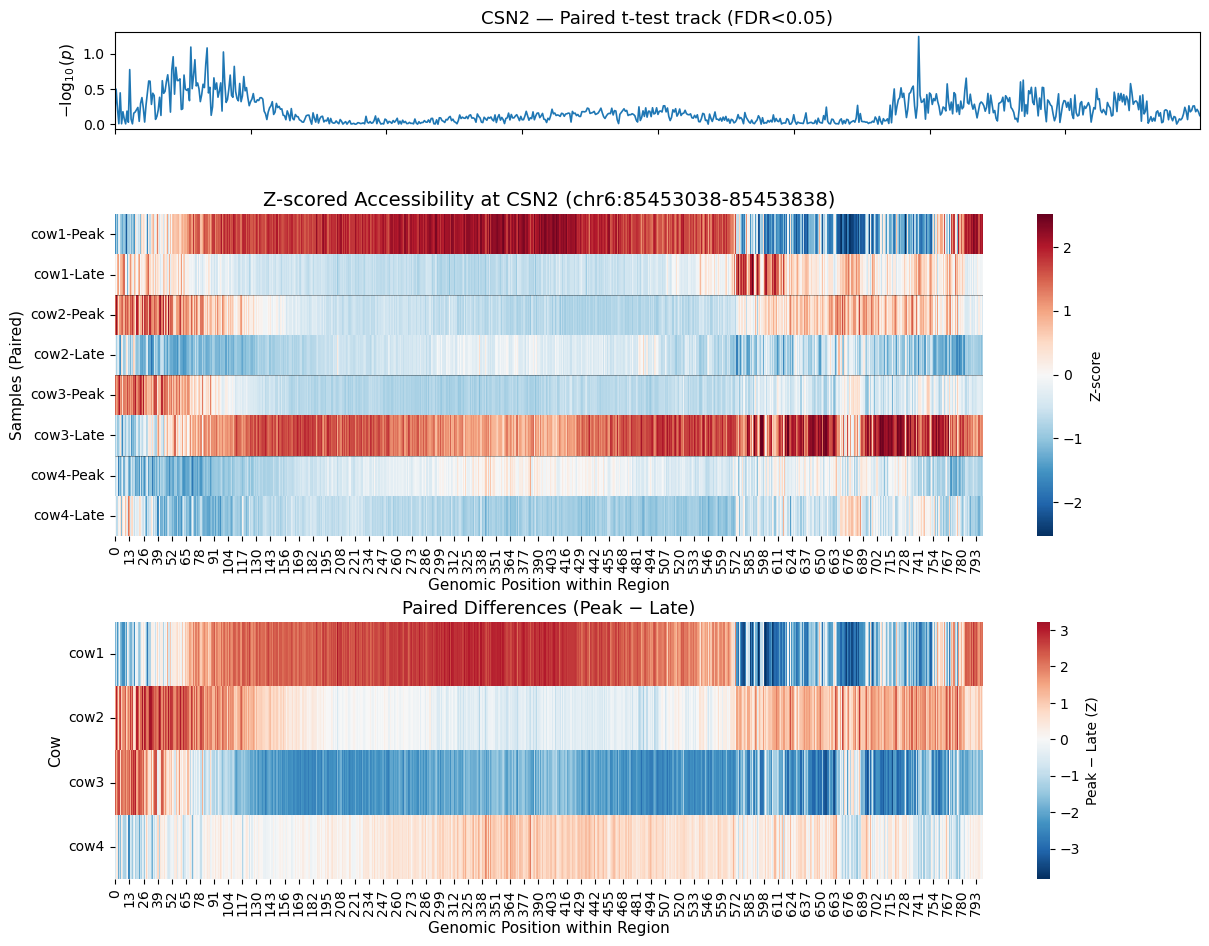

Plotting (paired): LALBA (chr5:31184781-31185581)


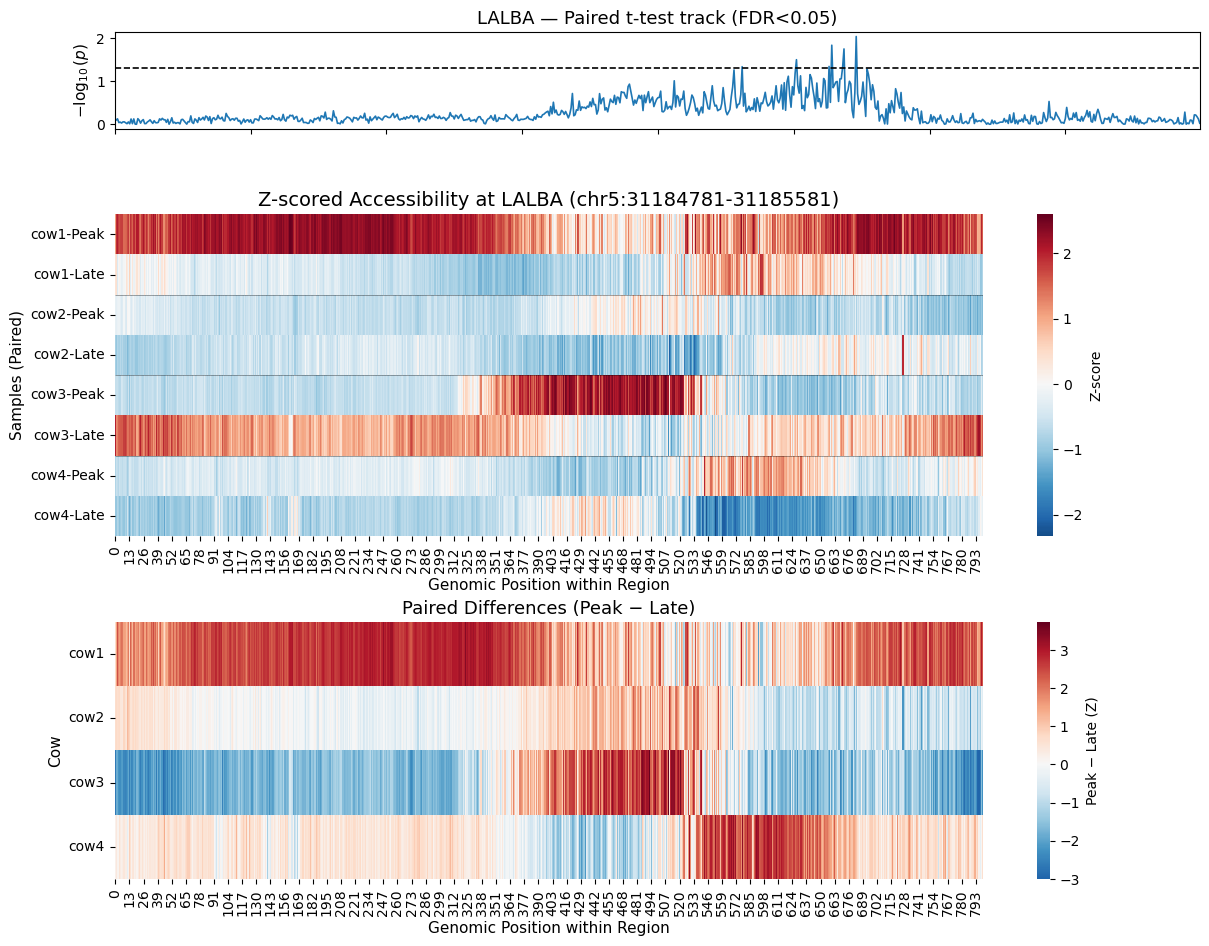

Plotting (paired): GPAM (chr26:32718888-32719688)


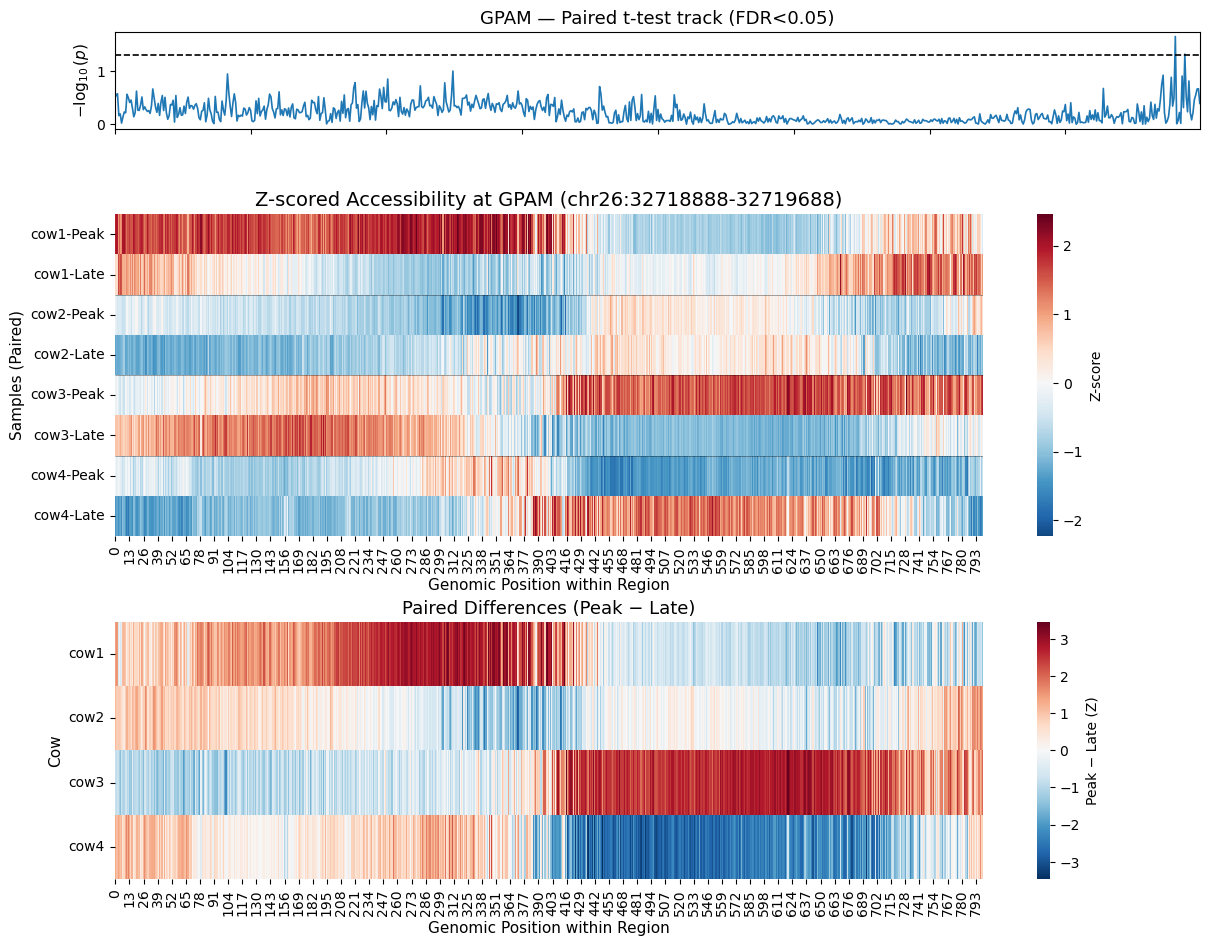

Plotting (paired): ACACA (chr19:13582530-13583330)


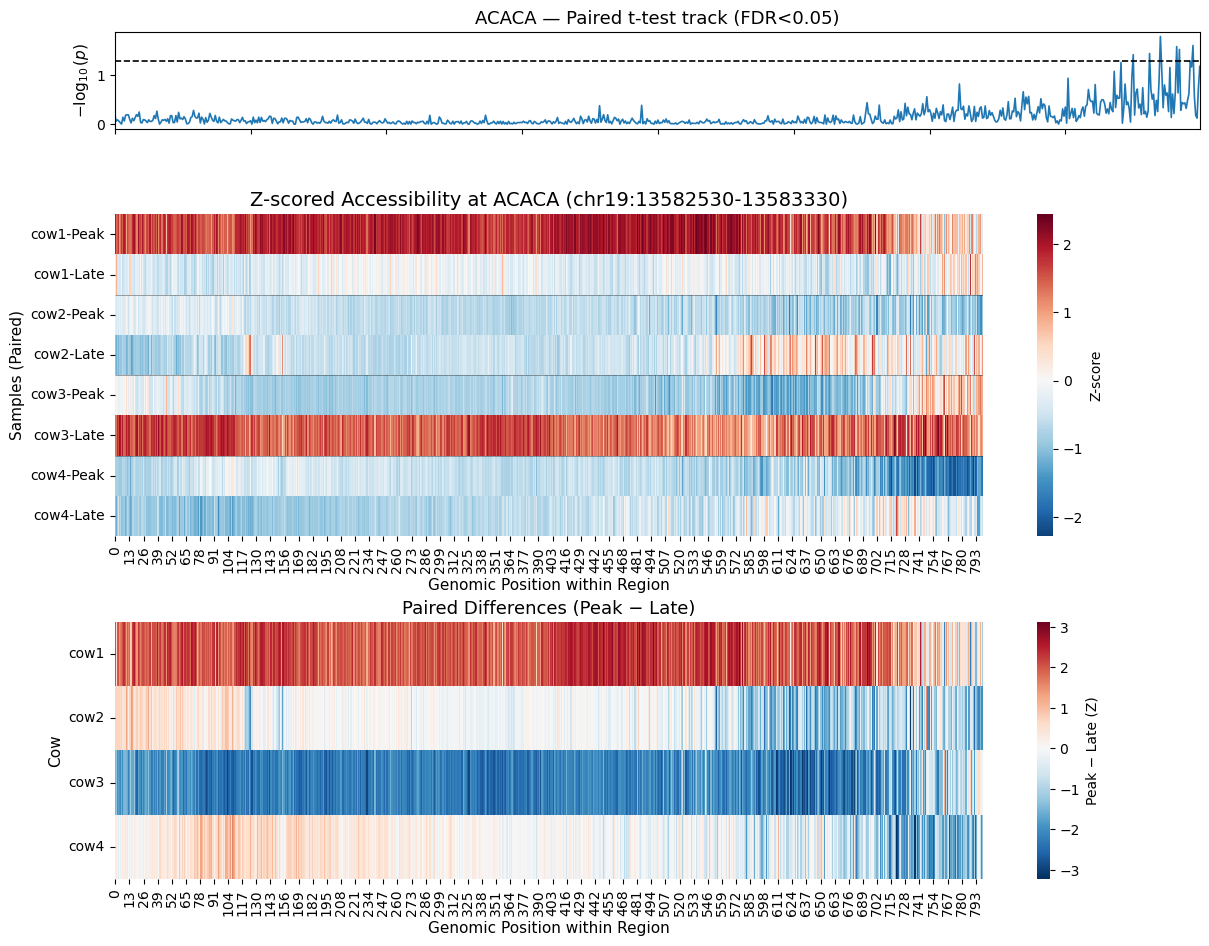

Plotting (paired): PPARGC1A (chr6:43737447-43738247)


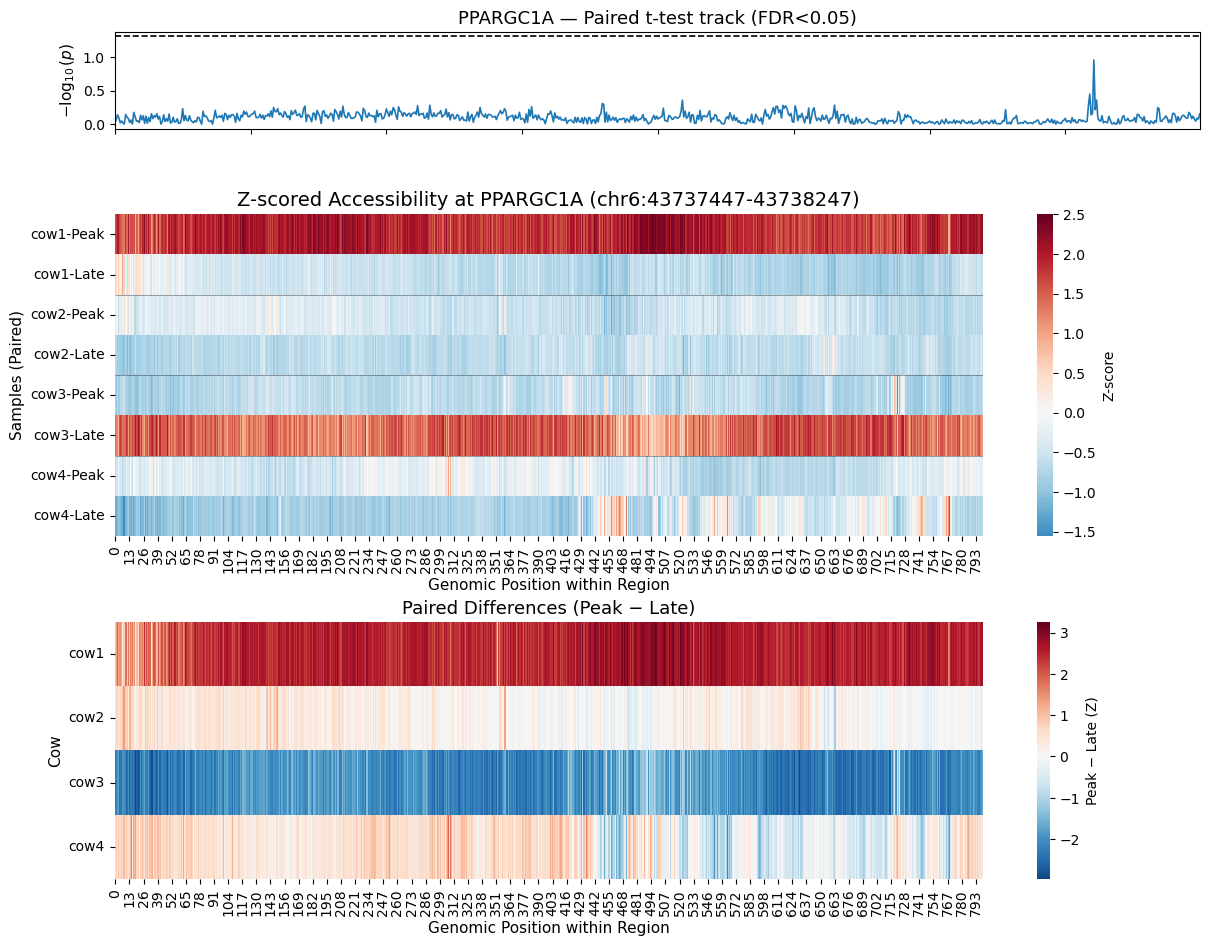

Plotting (paired): FASN (chr19:50785185-50785985)


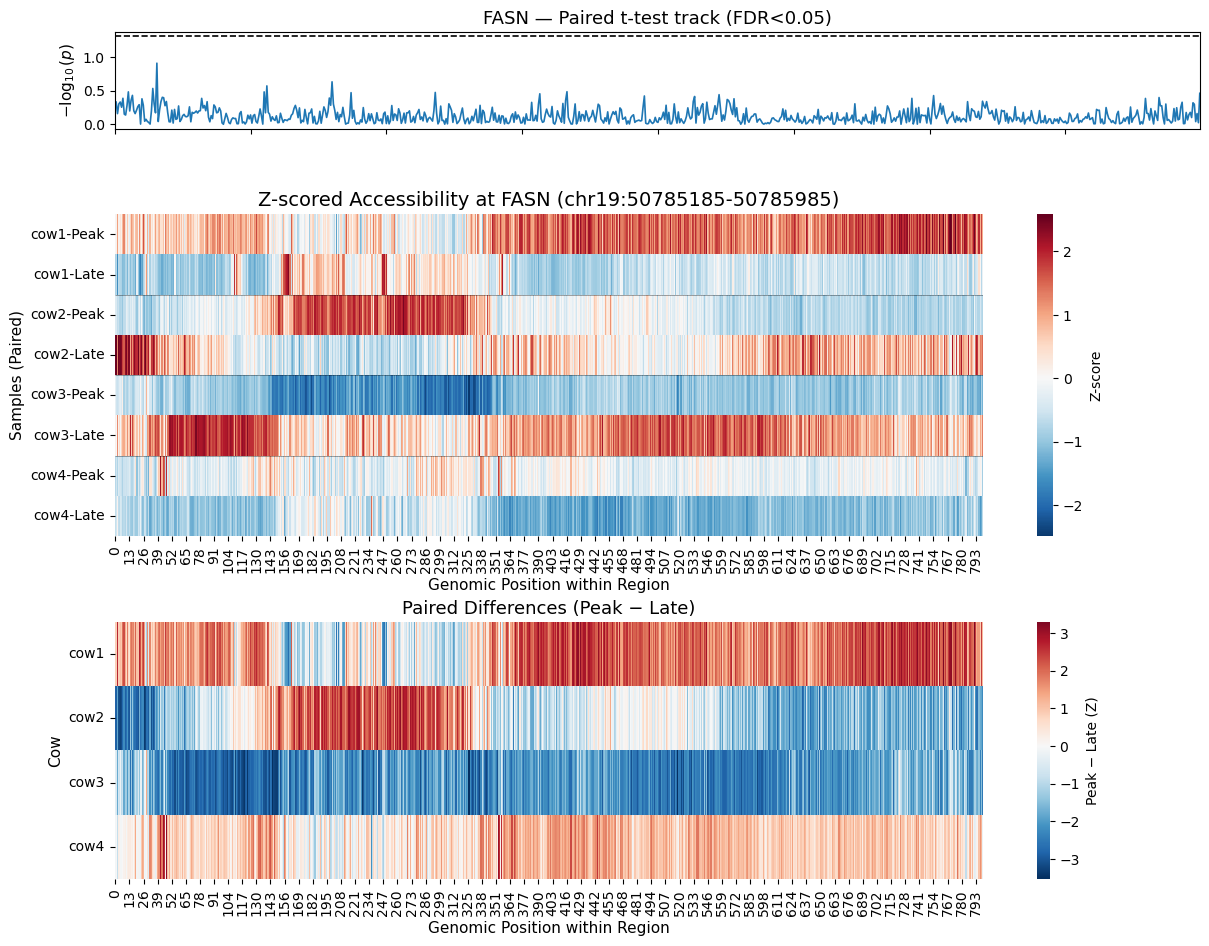

Plotting (paired): XDH (chr11:14194098-14194898)


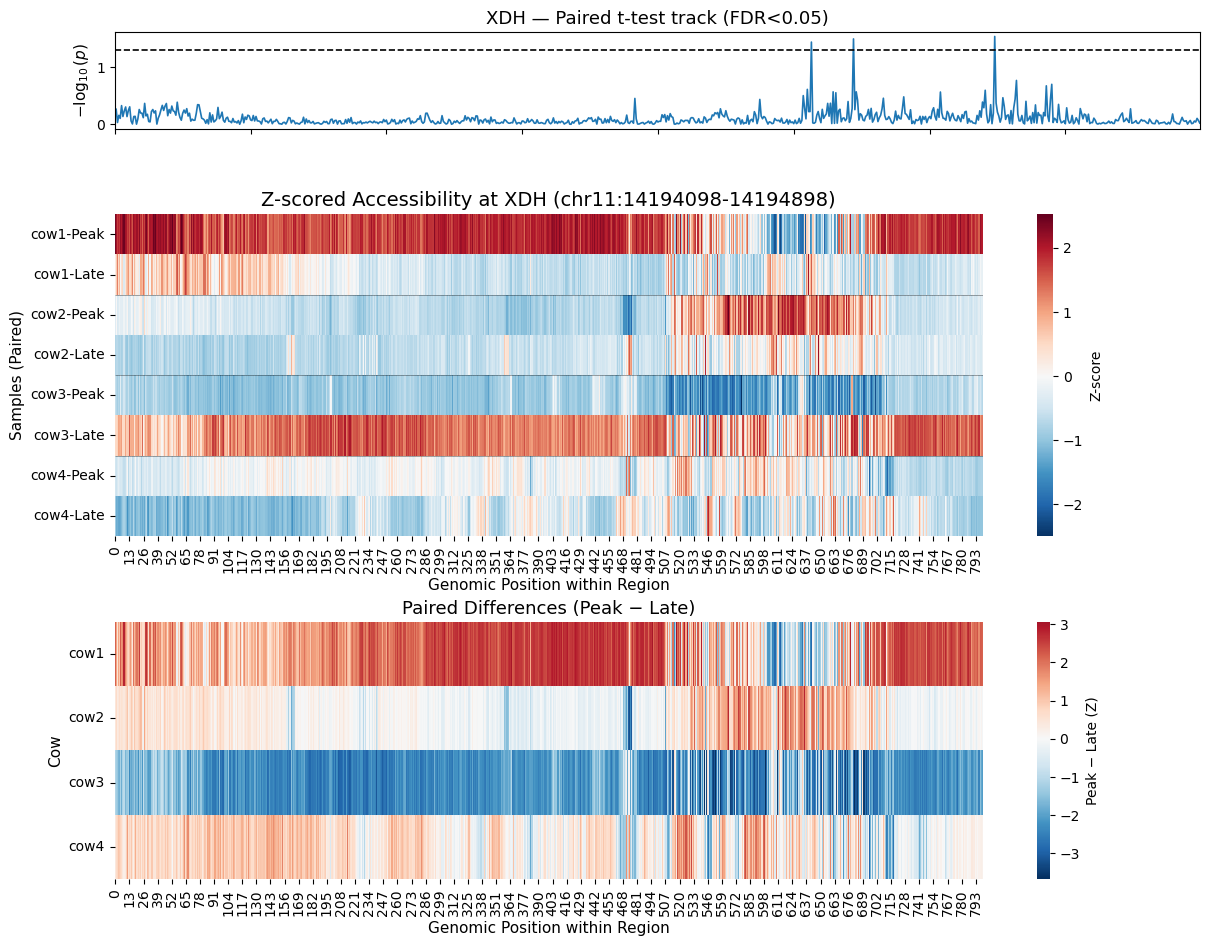

In [36]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

def build_pairs(right_samples, all_pairs):
    """
    Returns:
      pairs: list of (peak_id, late_id)
      cow_labels: list of "cow1", "cow2", ...
    """
    pairs = []
    cow_labels = []
    seen = set()
    cow_idx = 1
    
    # pick unique (peak -> late) mappings that are present
    for k, v in all_pairs.items():
        if not k.startswith("experiments_peak"):
            continue
        peak_id, late_id = k, v
        if peak_id in right_samples and late_id in right_samples:
            if (peak_id not in seen) and (late_id not in seen):
                pairs.append((peak_id, late_id))
                cow_labels.append(f"cow{cow_idx}")
                seen.update([peak_id, late_id])
                cow_idx += 1
    return pairs, cow_labels

if not os.path.exists(f'{work_dir}/plots'):
    os.makedirs(f'{work_dir}/plots')

for region, gene_name in regions_dict.items():
    print(f"Plotting (paired): {gene_name} ({region})")

    # We z-score each samples for make them comparable
    tfbs = np.array([adata_tfbs[sample].obsm[region] for sample in right_samples]).squeeze()
    tfbs_z = stats.zscore(tfbs, axis=0, nan_policy='omit')
    tfbs_z = np.nan_to_num(tfbs_z)

    # I wanna compare the difference in profiles for the SAME cow
    pairs, cow_labels = build_pairs(right_samples, all_pairs)
    name_to_idx = {s: i for i, s in enumerate(right_samples)}
    ordered_indices = []
    ordered_row_labels = []
    for ci, (peak_id, late_id) in enumerate(pairs):
        ordered_indices.extend([name_to_idx[peak_id], name_to_idx[late_id]])
        ordered_row_labels.extend([f"{cow_labels[ci]}-Peak", f"{cow_labels[ci]}-Late"])

    # Reoganize tfbs_z according to ordered_indices
    tfbs_z_ord = tfbs_z[ordered_indices, :]

    # Even rows will be peaks, odd rows will be paired lates
    peak_rows = tfbs_z_ord[0::2, :]
    late_rows = tfbs_z_ord[1::2, :]
    diff = peak_rows - late_rows

    # Since I grouped them, I can do a paired t-test
    # Uses original paired arrays (peak_rows vs late_rows)
    tvals, pvals = stats.ttest_rel(peak_rows, late_rows, axis=0, nan_policy="omit")

    # BH-FDR
    _, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
    neglog10_p = -np.log10(np.clip(pvals, 1e-300, 1.0))
    n_sig_05 = int((pvals_fdr < 0.05).sum())

    # Make a composite figure with three panels:
    #   A) –log10(p) track (paired t-test)
    #   B) Heatmap of z-scored samples ordered by pairs (with separators)
    #   C) Heatmap of paired differences (Peak − Late)
    
    n_pairs, n_pos = diff.shape

    # Layout
    fig = plt.figure(figsize=(14, 11))
    gs = gridspec.GridSpec(
        nrows=3, ncols=1,
        height_ratios=[1.2, 4.0, 3.2],
        hspace=0.38 # a litle bit more vertical space
    )

    # A) –log10(p) significance track: for comparing COW DIFFS
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(np.arange(n_pos), neglog10_p, linewidth=1.2)
    ax0.set_ylabel(r'$-\log_{10}(p)$', fontsize=11)
    ax0.set_xlim(0, n_pos - 1)
    ax0.set_title(f"{gene_name} — Paired t-test track (FDR<0.05)", fontsize=13)
    ax0.tick_params(axis='x', labelbottom=False)

    # Threshold line for p=0.05
    sig_threshold = -np.log10(0.05)
    ax0.axhline(sig_threshold, color='black', linestyle='--', linewidth=1.2)

    # Z-scored heatmap, ordered by cow pairs
    ax1 = fig.add_subplot(gs[1, 0])
    sns.heatmap(
        tfbs_z_ord, cmap='RdBu_r', center=0,
        yticklabels=ordered_row_labels,
        cbar_kws={'label': 'Z-score'}
    )
    ax1.set_ylabel("Samples (Paired)", fontsize=11)
    ax1.set_xlabel("Genomic Position within Region", fontsize=11)
    ax1.set_title(f"Z-scored Accessibility at {gene_name} ({region})", fontsize=14)
    plt.setp(ax1.get_yticklabels(), rotation=0)

    for r in range(2, 2 * n_pairs, 2):
        ax1.hlines(r, *ax1.get_xlim(), colors='k', linewidth=0.6, alpha=0.4)

    # Cow difference heatmap
    ax2 = fig.add_subplot(gs[2, 0])
    sns.heatmap(
        diff, cmap='RdBu_r', center=0,
        yticklabels=cow_labels,
        cbar_kws={'label': 'Peak − Late (Z)'}
    )
    ax2.set_ylabel("Cow", fontsize=11)
    ax2.set_xlabel("Genomic Position within Region", fontsize=11)
    ax2.set_title("Paired Differences (Peak − Late)", fontsize=13)
    plt.setp(ax2.get_yticklabels(), rotation=0)

    out_png = f'{work_dir}/plots/TFBS_Paired_{gene_name}_{region.replace(":", "_")}.png'
    plt.savefig(out_png, bbox_inches='tight', dpi=300)
    plt.show()


# Compute TF binding scores on a larger number of peaks

In [37]:
# First construct a peak-by-cell matrix of ATAC counts
peak_path = f'{work_dir}/peaks/chromvar_exp_regions.bed'
adata = scp.pp.make_peak_matrix(printer_exp,
                       regions=peak_path,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)
adata.write(f'{work_dir}/data/cell_peak.h5ad')

Making peak matrix:   0%|          | 0/345028 [00:00<?, ?it/s]

In [38]:
# Remove regions with low coverage (helps to reduce total peak number and save time. The full list of 300k peaks contains many very weak peaks)
regions = pd.read_csv(peak_path, sep='\t', header=None)
adata = anndata.read_h5ad(f'{work_dir}/data/cell_peak.h5ad')
peak_depth = np.array(np.sum(adata.X, axis=0)).squeeze()
regions_filt = regions.iloc[np.where(peak_depth > 200)[0], :]
regions_filt.to_csv(f'{work_dir}/data/regions_filt.bed', sep='\t', header=False, index=False)

In [ ]:
import json
for sample_ind, sample in enumerate(wrong_samples):
    scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer_exp.genome,
                          region_path=f'{work_dir}/data/regions_filt.bed',
                          gpus=[0],
                          model_type='seq2print',
                          model_path=model_path_dict[sample], # For now we just run on one fold
                          lora_config=json.load(open(f'{work_dir}/configs/Mammary_bulkATAC_{sample}_fold0.JSON', 'r')),
                          group_names=[sample],
                          verbose=True,
                          launch=True,
                          return_adata=False,
                          overwrite_seqattr=True,
                          post_normalize=True,
                          save_key=f'Mammary_bulkATAC_{sample}', # and input a save_key
                          save_path=work_dir)

Automatic locating seq_attr_count
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: count
using nth_output: 0
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/regions_filt.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_0 --overwrite --model_norm count
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits

validating loci:   0%|          | 0/77056 [00:00<?, ?it/s]

valid summits after trimming edges 77056


fetching coverage:   0%|          | 0/77056 [00:00<?, ?it/s]

(77056, 1)
coverage min max 815.82495 1375.6868
valid summits after min/max count filter 77056


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/77056 [00:00<?, ?it/s]

  0%|          | 0/77056 [00:00<?, ?it/s]

the estimated norm on prem is -0.0008386135450564325 8.466243889415637e-05 0.0008483171695843339
normalizing -0.0008429288864135742 8.652657197671942e-05 0.0008458614465780556


  0%|          | 0/54515 [00:00<?, ?it/s]

Automatic locating seq_attr_footprint
/net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt seq attr file does not exist
Using preset, the following parameters would be overwritten
using wrapper: just_sum
using nth_output: 0-30
using decay: 0.85
Launching the following command now (no action needed from your side)
seq2print_attr --pt /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/model/Mammary_bulkATAC_experiments_peak_0_fold0-gentle-frog-1.pt --peaks /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/regions_filt.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/custom_genomes/bosTau9 --decay 0.85 --save_key Mammary_bulkATAC_experiments_peak_0 --overwrite --model_norm footprint
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom 

validating loci:   0%|          | 0/77056 [00:00<?, ?it/s]

valid summits after trimming edges 77056


fetching coverage:   0%|          | 0/77056 [00:00<?, ?it/s]

(77056, 1)
coverage min max 815.82495 1375.6868
valid summits after min/max count filter 77056


  0%|          | 0/1 [00:00<?, ?it/s]

Caching sequences:   0%|          | 0/77056 [00:00<?, ?it/s]

  0%|          | 0/77056 [00:00<?, ?it/s]

In [40]:
# We first scan TF motifs across all regions to find motif matched sites

# Initialize motif set object
motifs = scp.motifs.FigR_Human_Motifs(genome=printer_exp.genome, bg=[0.25] * 4)

# Prepare motif scanner. Here you can specify which TF motifs you want to scan using tf_genes. If tf_genes=None then use all motifs
motifs.prep_scanner()

# Scan motif sites. This will return the exact genomic coordinates of motif matches
motif_sites = motifs.scan_motif(regions_filt, verbose=True, clean=True)

# Reformat motif matches to a pandas DataFrame
motif_sites = pd.DataFrame(motif_sites)
motif_sites.iloc[:, 2] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 8]
motif_sites.iloc[:, 1] = motif_sites.iloc[:, 1] + motif_sites.iloc[:, 7]
motif_sites = motif_sites.iloc[:, [0,1,2,4]]
motif_sites.columns=["chrom", "start", "end", "TF"]

  0%|          | 0/154094 [00:00<?, ?it/s]

In [ ]:
import pyBigWig as pw

bw = f"{work_dir}/{[wrong_samples[0]][0]}_TFBS.bigwig"
with pw.open(bw) as f:
    bw_chroms = f.chroms()

# What is going ON??
print("motif chroms (unique):", sorted(set(motif_sites.chrom)))
print("bw chroms:", sorted(bw_chroms.keys()))

# Find first offending chromosome where genome size > BigWig size (or missing)
offenders = []
for chrom, gsize in printer_exp.genome.chrom_sizes.items():
    bsize = bw_chroms.get(chrom)
    if bsize is None:
        offenders.append((chrom, "missing_in_bw"))
    elif int(gsize) > int(bsize):
        offenders.append((chrom, f"genome:{gsize} > bw:{bsize}"))
print("mismatches:", offenders[:10])


motif chroms (unique): ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr23', 'chr24', 'chr25', 'chr26', 'chr27', 'chr28', 'chr29', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']
bw chroms: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr23', 'chr24', 'chr25', 'chr26', 'chr27', 'chr28', 'chr29', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']
mismatches: [('chrM', 'missing_in_bw'), ('chrUn_NW_020190115v1', 'missing_in_bw'), ('chrUn_NW_020190116v1', 'missing_in_bw'), ('chrUn_NW_020190117v1', 'missing_in_bw'), ('chrUn_NW_020190118v1', 'missing_in_bw'), ('chrUn_NW_020190119v1', 'missing_in_bw'), ('chrUn_NW_020190120v1', 'missing_in_bw'), ('chrUn_NW_020190121v1', 'missing_in_bw'), ('chrUn_NW_020190122v1', 'missing_in_bw'), ('chrUn_NW_020190123v1', 'missing_in_bw')]


In [58]:
# We then extract the TF binding scores at those motif sites
def fetch_bw(args):
    TFBS, bw, genome = args
    chroms, starts, ends = np.array(TFBS['chrom']),np.array(TFBS['start']),np.array(TFBS['end'])
    res_all = {}
    with pw.open(bw, 'r') as f:
        for chrom in tqdm(genome.chrom_sizes):
            if chrom == 'chrY' or chrom == 'chrM' or chrom.startswith('chrUn_'):
                continue
            print (f'Fetching chrom: {chrom} ...')
            res_all[chrom] = f.values(chrom, 0, genome.chrom_sizes[chrom], numpy=True)

    vs = []
    for chr, left, right in zip(tqdm(chroms, mininterval=1), starts, ends):
        vs.append(np.nanmean(res_all[chr][left:right]))
    return vs

# Multi-process loading of TF binding scores
bigwig_dict = {sample:f"{work_dir}/{sample}_TFBS.bigwig" for sample in [wrong_samples[0]]}
args = [[motif_sites, bigwig_dict[sample], printer_exp.genome] for sample in [wrong_samples[0]]]
n_jobs = 4
import multiprocessing as mp
with mp.Pool(n_jobs) as pool:
    TFBS_scores = list(pool.imap(fetch_bw, args))
TFBS_scores = np.array(TFBS_scores).T
TFBS_scores = pd.DataFrame(TFBS_scores, columns=[f"TFBS_{sample}" for sample in [wrong_samples[0]]])
TFBS_scores = pd.concat([motif_sites, TFBS_scores], axis=1)

Fetching chrom: chr1 ...
Fetching chrom: chr10 ...
Fetching chrom: chr11 ...
Fetching chrom: chr12 ...
Fetching chrom: chr13 ...
Fetching chrom: chr14 ...
Fetching chrom: chr15 ...
Fetching chrom: chr16 ...
Fetching chrom: chr17 ...
Fetching chrom: chr18 ...
Fetching chrom: chr19 ...
Fetching chrom: chr2 ...
Fetching chrom: chr20 ...
Fetching chrom: chr21 ...
Fetching chrom: chr22 ...
Fetching chrom: chr23 ...
Fetching chrom: chr24 ...
Fetching chrom: chr25 ...
Fetching chrom: chr26 ...
Fetching chrom: chr27 ...
Fetching chrom: chr28 ...
Fetching chrom: chr29 ...
Fetching chrom: chr3 ...
Fetching chrom: chr4 ...
Fetching chrom: chr5 ...
Fetching chrom: chr6 ...
Fetching chrom: chr7 ...
Fetching chrom: chr8 ...
Fetching chrom: chr9 ...
Fetching chrom: chrX ...


  0%|          | 0/5173386 [00:00<?, ?it/s]

/net/talisker/home/benos/mae117/.local/share/Trash/ipykernel_862153/3137022707.py:15: RuntimeWarning: Mean of empty slice
  vs.append(np.nanmean(res_all[chr][left:right]))


In [59]:
TFBS_scores

,chrom,start,end,TF,TFBS_experiments_peak_0
0,chr1,35574,35583,ARNT2,0.104851
1,chr1,35665,35674,ARNT2,0.113352
2,chr1,35711,35720,ARNT2,0.098688
3,chr1,35574,35583,ARNTL,0.104851
4,chr1,35665,35674,ARNTL,0.113352
...,...,...,...,...,...
5173381,chrX,138921013,138921030,ZNF79,0.054067
5173382,chrX,138921063,138921074,ZNF793,0.065901
5173383,chrX,138921130,138921144,ZNF821,0.063243
5173384,chrX,138921009,138921029,ZNF98,0.052647


In [61]:
ranked_tfs = TFBS_scores.groupby('TF')['TFBS_experiments_peak_0'].mean().sort_values(ascending=False)

print("Top 20 Predicted TFs:")
print(ranked_tfs.head(20))

# Convert the results into a clean DataFrame for saving
ranked_tfs_df = ranked_tfs.reset_index()
ranked_tfs_df.columns = ['TF', 'Mean_Predicted_Score'] # Assign clear column names

# Define the output filename
output_filename = f'{work_dir}/data/ranked_transcription_factors.csv'

# Save the DataFrame to a CSV file
ranked_tfs_df.to_csv(output_filename, index=False) # index=False prevents writing an extra column for row numbers

print(f"\nSuccessfully saved the ranked TF list to: {output_filename}")

Top 20 Predicted TFs:
TF
ZNF211     0.074395
ZBTB32     0.072245
DMRTA2     0.071434
IRX3       0.071420
DMRTC2     0.071350
SOX10      0.071201
IRX1       0.071015
NFIA       0.070962
NEUROD4    0.070941
NEUROD1    0.070941
SOX18      0.070936
MESP2      0.070788
DMRTA1     0.070778
NEUROD2    0.070762
SOX2       0.070758
SOX15      0.070739
NFE2L1     0.070699
FOXP3      0.070692
DMRT1      0.070621
TET3       0.070523
Name: TFBS_experiments_peak_0, dtype: float32

Successfully saved the ranked TF list to: /net/talisker/home/benos/mae117/Documents/careers/opalia/the-milk-man/data/ranked_transcription_factors.csv


In [62]:
printer_exp.close()